# Cluster Modeling

In [32]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
from dateutil.parser import parse 
import pymysql # Import MySql 
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

from scipy import signal
from scipy.special import inv_boxcox
from scipy import stats as stats # Used for calculating z-values

import numpy as np # Used for calculating statistics on data
import random
import math
from math import sqrt, log, exp
import itertools

import pandas as pd # Used for loading-in and viewing data


import matplotlib.pyplot as plt # Used for creating graphics
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.pylab import rcParams 
from pylab import *
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

import statsmodels.api as sm

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots




%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# to make this notebook's output identical at every run
np.random.seed(42)

# Functions Definitions

In [2]:
def read_data(file_name, index):
    df = pd.read_csv(file_name, sep=',', index_col=index, header='infer', float_precision=2 )
    return df

def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def update_df(df_household, df, column):
    df_household[column] = df[column]
    return df_household

def road_side_usage(calls):
    if calls > 0: return 1
    elif calls == 0: return 0
    else: return np.nan

def fill_with_zeros(df_household, fields):
    for i in fields:
        df_household[i].fillna(value=0, inplace=True)
    return df_household

def join_data_from_models(df_household, fields):
    # Create feature Cancel = 1 - member cancelled, if 0 active member
    df_household['aaa_cancel'] = 1
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'ACTIVE', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'PENDING', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'CANCELLED', 1, 
                                        df_household['aaa_cancel'])
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))

    df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                           df_household.consumer_score)

    df_household.consumer_score = np.where(~(df_household.consumer_score > 0), df_household.consumer_score.mean(), 
                                           df_household.consumer_score)

    df_household.consumer_score = np.where(df_household.consumer_score== np.nan, df_household.consumer_score.mean(), 
                                           df_household.consumer_score)

    # Join results to main dataframe
    df_household = update_df(df_household, df_auto_insurance, 'yes_auto_insurance')
    df_household = update_df(df_household, df_cancel, 'will_cancel_prob')
    df_household = update_df(df_household, df_credit_card, 'yes_credit_card')
    df_household = update_df(df_household, df_deposit,'yes_deposit')
    df_household = update_df(df_household, df_home_equity, 'yes_home_equity')
    df_household = update_df(df_household, df_id_theft, 'yes_id_theft')
    df_household = update_df(df_household, df_mortgage, 'yes_mortgage')
    df_household = update_df(df_household, df_roadside, 'yes_roadside')
    df_household = update_df(df_household, df_travel, 'yes_travel')
    df_household = update_df(df_household, df_costs, 'estimated_cost')
    df_household['aaa_mean_age'] = np.round(df_household['aaa_mean_age'],0)
    df_household['aaa_mean_child'] = np.round(df_household['aaa_mean_child'],0)
    df_household = fill_with_zeros(df_household,fields)
    # Remove members with status CANCELLED
    df_household = df_household[df_household.member_status!='CANCELLED']
    return df_household

# Load Data outcomes from models

In [4]:
# Load House hold Data 
df_household = read_data('household_view.csv', 'membership_id')
# Load outcome of auto insurance model
df_auto_insurance = read_data('auto_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of customer cancel model
df_cancel = read_data('cancel_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of credit card model
df_credit_card = read_data('credit_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of deposit model
df_deposit = read_data('deposit_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of home equity model
df_home_equity = read_data('hequity_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of ID Theft model
df_id_theft = read_data('idtheft_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Mortgage and Financial Services model
df_mortgage = read_data('mortgage_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Roadside model
df_roadside = read_data('rds_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Cost Prediction model
df_costs = read_data('totc_no_gap_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Cost Prediction model
df_travel = read_data('travel_reduced_feature_outcome.csv', 'membership_id')

# Join results to main dataframe

In [5]:
fields = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card', 'yes_deposit',
          'yes_home_equity', 'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel',
          'estimated_cost', 'aaa_mean_age', 'aaa_mean_child', 
         ]
df_household = join_data_from_models(df_household, fields)

In [219]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 97 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

# Cluster KMeans Model

In [220]:
# Verify is there is no nulls
df_household[df_household.isnull().any(axis=1)].head(5)

,household_key,income,member_status,state_grouped,credit_ranges,cancel_reason,renew_method,plus_indicator_description,zip,sc_vehicle_manufacturer_name,sc_vehicle_model_name,race,home_owner,education,dwelling_type,gender,occupation_code,occupation_group,occupant_type,mosaic_household,mosaic_global_household,kcl_b_ind_mosaicsgrouping,generation,tenure,aaa_no_tenure,aaa_member_tenure_years,aaa_mean_age,length_of_residence,aaa_mortgage,aaa_credit_card,aaa_deposit,aaa_home_equity,aaa_financial_service,aaa_auto_insurance,aaa_id_theft,aaa_motorcycle_indicator,aaa_travel,aaa_mean_child,aaa_mean_total_cost,aaa_no_race,aaa_no_home_owner,aaa_no_education,aaa_no_income,aaa_no_dwelling_type,aaa_no_credit_ranges,aaa_no_gender,aaa_no_language,aaa_no_reason_joined,aaa_cancel_reason,aaa_no_mosaic_household,aaa_no_mosaic_global_household,aaa_no_kcl_b_ind_mosaicsgrouping,aaa_no_occupation_code,aaa_no_occupation_group,aaa_no_occupant_type,aaa_no_plus_indicator_description,aaa_no_generation,total_calls_year_1,total_calls_year_2,total_calls_year_3,total_member_cost_1,total_member_cost_2,total_member_cost_3,basic_cost,plus_cost,premier_cost,mean_basic_cost,mean_plus_cost,mean_premier_cost,total_calls,total_member_cost,mean_total_member_cost,total_tow_miles,mean_tow_miles,vehicle,total_cost,mean_total_cost,total_members_in_household,total_calls_veh,total_cost_veh,total_member_cost_veh,mean_total_calls_veh,mean_total_cost_veh,mean_total_member_cost_veh,consumer_score,aaa_cancel,use_road_side,yes_auto_insurance,will_cancel_prob,yes_credit_card,yes_deposit,yes_home_equity,yes_id_theft,yes_mortgage,yes_roadside,yes_travel,estimated_cost
membership_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
153,4500791,"30-39,999",ACTIVE,RI,600-649,UNKNOWN,AUTO RENEW,BASIC MEMBERSHIP,2893,TOYOTA,CAMRY,CAUCASION / WHITE - ENGLISH,HOME OWNER,SOME COLLEGE,SMALL OR LARGE MULTI-FAMILY W/APT NUMBER,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SENIOR DISCOUNTS,LOW INCOME ELDERS,GOLDEN YEAR GUARDIANS,POST-WAR (< 1948),+40 YEARS,0,49,97.0000,15.0000,0,1,0,0,0,0,0,0.0000,0,2.0000,33.8333,2.0000,0.0000,1.0000,8.0000,2.0000,5.0000,nan,0.0000,nan,nan,11.0000,7.0000,3.0000,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,18.0000,0.0000,0.0000,585.0000,304.5000,0.0000,0.0000,33.8333,0.0000,0.0000,18.0000,585.0000,65.0000,0.8000,0.0889,TOYOTA CAMRY,304.5000,33.8333,1,5836.0000,107732.6600,303128.5500,2.5485,47.0448,132.3705,0.0137,0,1,0.5900,0.2140,1.0000,0.0000,0.0000,0.4000,0.3200,1.0000,0.1300,253.2011
163,11622991,"50-59,999",ACTIVE,RI,750-799,UNKNOWN,AUTO RENEW,BASIC MEMBERSHIP,2889,SUBARU,BRZ,HISPANIC - HISPANIC ORIGIN,HOME OWNER,UNKNOWN,SFDU,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,NO PLACE LIKE HOME,ROUTINE SERVICE WORKERS,THRIVING BOOMERS,MILLENIALS (1981 - 1993),BETWEEN 1 & 5 YEARS,6,59,48.0000,8.5556,0,0,0,0,0,0,0,1.0000,0,1.0000,39.2056,6.0000,0.0000,2.0000,4.0000,0.0000,1.0000,nan,0.0000,nan,1.0000,3.0000,3.0000,4.0000,nan,nan,nan,2.0000,3.0000,3.0000,6.0000,0.0000,176.5500,353.1000,0.0000,352.8500,0.0000,0.0000,39.2056,0.0000,0.0000,9.0000,529.6500,58.8500,0.0000,0.0000,SUBARU BRZ,352.8500,39.2056,4,1153.0000,22582.1100,56317.2900,2.3971,46.9483,117.0838,0.0123,0,1,0.3200,0.0200,0.0600,0.0000,0.0000,0.3200,0.4400,1.0000,0.1100,252.9946
182,579810,"50-59,999",ACTIVE,RI,650-699,UNKNOWN,NOTICE,BASIC MEMBERSHIP,2863,INFINITI,QX56,CAUCASION / WHITE - EUROPEAN,HOME OWNER,SOME COLLEGE,SFDU,MALE,RETIRED,RETIRED - KNOWN,UNKNOWN,TOWN ELDERS,COMFORTABLE RETIREMENT,GOLDEN YEAR GUARDIANS,POST-WAR (< 1948),+40 YEARS,0,59,83.0000,15.0000,0,0,0,0,0,1,0,0.0000,0,1.0000,28.0000,1.0000,0.0000,1.0000,4.0000,0.0000,3.0000,2.0000,0.0000,nan,nan,6.0000,1.0000,3.0000,1.0000,3.0000,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,28.0000,0.0000,0.0000,28.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,INFINITI QX56,28.0000,28.0000,1,337.0000,4289.6000,18754.4000,3.7444,47.6622,208.3822,0.0143,0,0,1.0000,0.3222,0.2700,0.0000,0.0000,0.2800,0.1900,0.8800,0.13

In [221]:
fields_cluster = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card', 'yes_deposit',
                  'yes_home_equity', 'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel','zip',
                  'estimated_cost', 'total_calls' , 'total_members_in_household', 'aaa_mean_age', 'aaa_mean_child',
                  'aaa_member_tenure_years',  'basic_cost', 'plus_cost', 'premier_cost', 'length_of_residence',
                  'consumer_score', 'mean_tow_miles'
                 ]

In [226]:
# Initialize the model
np.random.seed(42)
fields_cluster = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card','yes_home_equity',
                  'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel', 'yes_deposit',
                  'estimated_cost', 'aaa_member_tenure_years',
                  'total_members_in_household'
                 ]

df_cluster = pd.DataFrame(df_household, columns=fields_cluster, index=df_household.index)
cluster_mm = PowerTransformer().fit_transform(df_cluster)
scaled_df_mm = pd.DataFrame(cluster_mm, columns=fields_cluster, index=df_household.index)

means = KMeans(n_clusters=10)

# Elbow Curve
Determine the number of Clsuters

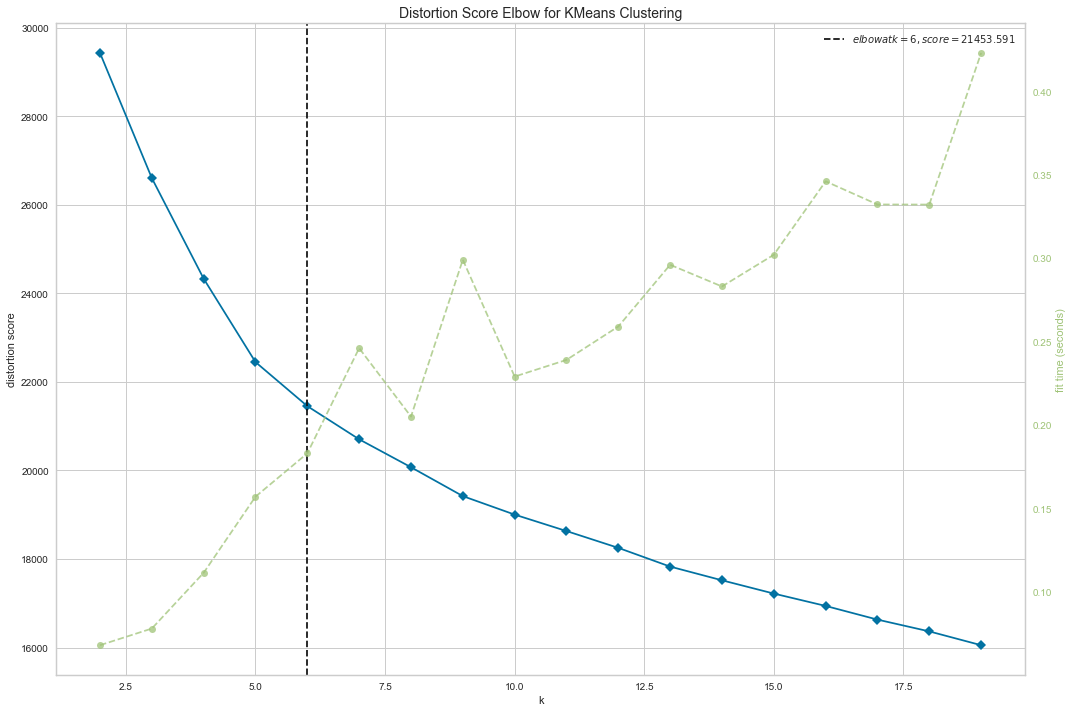

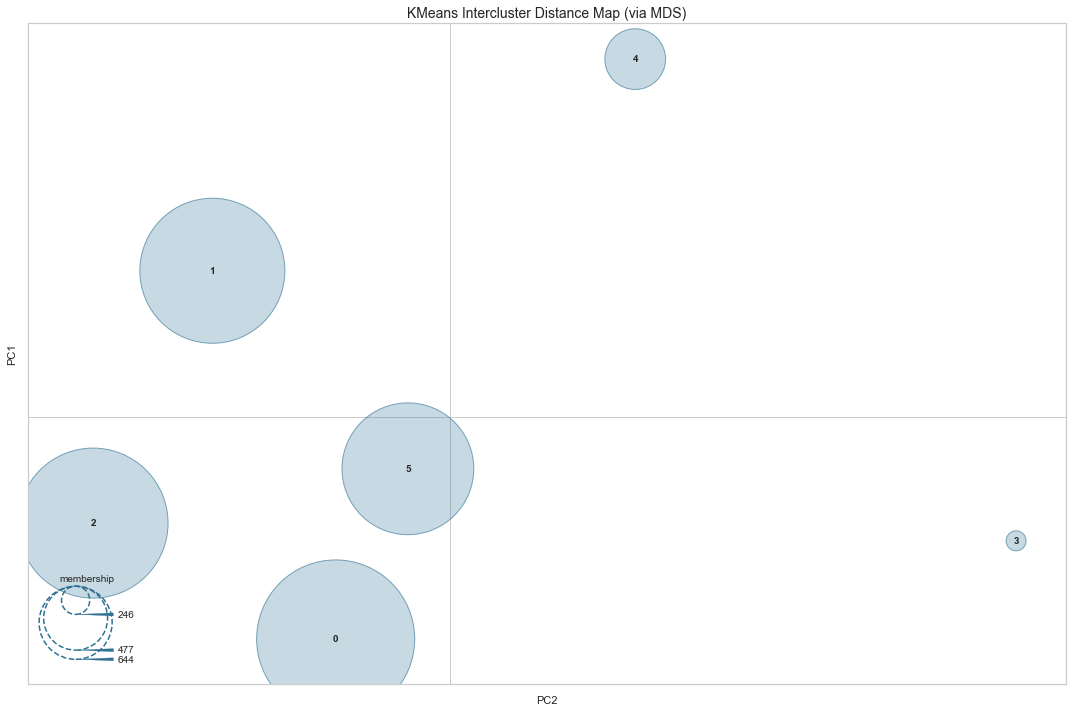

In [227]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
np.random.seed(42)

# Elbow Curve
visualizer = KElbowVisualizer(means, k=(2,20), size=(1080, 720))
visualizer.fit(scaled_df_mm)        # Fit the data to the visualizer
visualizer.show(outpath='./model_pics/cluster/'+'Elbow_Curve.png')        # Finalize and render the figure
plt.show()

# Intra Cluster Distance
visualizer = InterclusterDistance(KMeans(6), size=(1080, 720))
visualizer.fit(scaled_df_mm)        # Fit the data to the visualizer
visualizer.show(outpath='./model_pics/cluster/'+'intra_distance.png')
plt.show()

3    739
1    649
0    592
2    474
4    246
5    237
Name: Cluster, dtype: int64


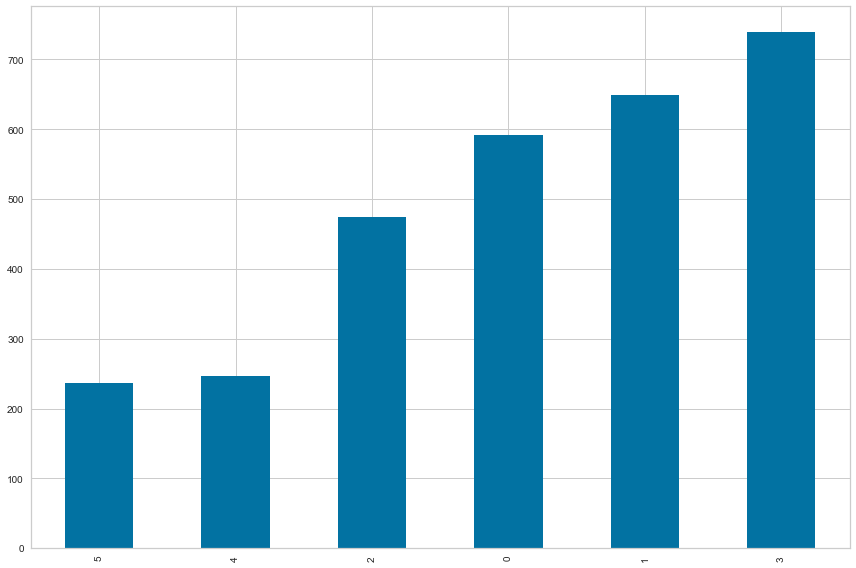

In [228]:
# Following the recommendation above, 6 clusters
means = KMeans(n_clusters=6)
means.fit(scaled_df_mm)
df_household = df_household.assign(Cluster=means.labels_)
print(df_household.Cluster.value_counts())
df_household.Cluster.value_counts(ascending=True).plot(kind='bar')
plt.show()

# Calculate Customer Live Value

* It is a Measurement of customer value
* Can be historical or predicted

* The goal of CLV
    * Measure customer value in revenue / profit 
    * Benchmark customers
    * Identify maximum investment into customer acquisition

# As we do not have the profit margin, we will skip it and do a basic calculation of CLV

CLV = Average Revenue * life Spam

In [11]:
df_transaction = pd.read_csv('capstone_aaa_featured_no_gaps.csv', 
                             parse_dates=['sc_date', 'birth_date_mmddyyyy', 'call_status_recv_date',
                                         'date_of_birth','active_expiration_date', 'cancel_date',
                                         'join_aaa_date', 'join_club_date', 'reinstate_date'
                                         ], 
                             infer_datetime_format=True)
df_transaction.call_status_recv_date = df_transaction.sc_date

In [12]:
df_transaction.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26006 entries, 0 to 26005
Data columns (total 167 columns):
id                                int64
individual_key                    int64
household_key                     int64
member_flag                       int64
city                              object
state_grouped                     object
zip5                              int64
zip9                              int64
fsv_cmsi_flag                     int64
fsv_credit_card_flag              int64
fsv_deposit_program_flag          int64
fsv_home_equity_flag              int64
fsv_id_theft_flag                 int64
fsv_mortgage_flag                 int64
ins_client_flag                   int64
trv_globalware_flag               int64
number_of_children                object
responded_to_catalog              object
race                              object
length_of_residence               int64
mail_responder                    object
home_owner                        object
inc

In [20]:
# AAA Costs
monthly_aaa_costs = df_transaction.groupby(by=['membership_id','csrd_yyyy'])['total_cost'].sum().mean()
monthly_aaa_costs = np.mean(yearly_aaa_costs)

# AAA Revenue
monthly_aaa_rev = df_transaction.groupby(by=['membership_id','csrd_yyyy'])['total_member_cost'].sum().mean()
monthly_aaa_rev = np.mean(yearly_aaa_rev)


# Define Lifespam

lifespam = 36
# Calculate Basic CLV
clv_basic = (monthly_aaa_rev-monthly_aaa_costs) * lifespam
print('The average basic CLV (Revenue) is {:.1f} USD'.format(clv_basic))

The average basic CLV (Revenue) is 6628.3 USD


In [16]:
df_transaction.groupby(by=['membership_id','csrd_yyyymm'])['total_cost'].sum().mean()*36

1936.6533174969816

In [234]:
cust_month_tx = pd.pivot_table(data=df_transaction, index=['membership_id'],
                               values='total_cost',
                               columns=['sc_date'],
                               aggfunc=np.sum, fill_value=0)
cust_month_tx.head()

sc_date,2014-06-01,2014-06-02,2014-06-03,2014-06-04,2014-06-05,2014-06-06,2014-06-07,2014-06-08,2014-06-09,2014-06-10,2014-06-11,2014-06-12,2014-06-13,2014-06-14,2014-06-15,2014-06-16,2014-06-17,2014-06-18,2014-06-19,2014-06-20,2014-06-21,2014-06-22,2014-06-23,2014-06-24,2014-06-25,2014-06-26,2014-06-27,2014-06-28,2014-06-29,2014-06-30,2014-07-01,2014-07-02,2014-07-03,2014-07-04,2014-07-05,2014-07-06,2014-07-07,2014-07-08,2014-07-09,2014-07-10,2014-07-11,2014-07-12,2014-07-13,2014-07-14,2014-07-15,2014-07-16,2014-07-17,2014-07-18,2014-07-19,2014-07-20,2014-07-21,2014-07-22,2014-07-23,2014-07-24,2014-07-25,2014-07-26,2014-07-27,2014-07-28,2014-07-29,2014-07-30,2014-07-31,2014-08-01,2014-08-02,2014-08-03,2014-08-04,2014-08-05,2014-08-06,2014-08-07,2014-08-08,2014-08-09,2014-08-10,2014-08-11,2014-08-12,2014-08-13,2014-08-14,2014-08-15,2014-08-16,2014-08-17,2014-08-18,2014-08-19,2014-08-20,2014-08-21,2014-08-22,2014-08-23,2014-08-24,2014-08-25,2014-08-26,2014-08-27,2014-08-28,2014-08-29,2014-08-30,2014-08-31,2014-09-01,2014-09-02,2014-09-03,2014-09-04,2014-09-05,2014-09-06,2014-09-07,2014-09-08,2014-09-09,2014-09-10,2014-09-11,2014-09-12,2014-09-13,2014-09-14,2014-09-15,2014-09-16,2014-09-17,2014-09-18,2014-09-19,2014-09-20,2014-09-21,2014-09-22,2014-09-23,2014-09-24,2014-09-25,2014-09-26,2014-09-27,2014-09-28,2014-09-29,2014-09-30,2014-10-01,2014-10-02,2014-10-03,2014-10-04,2014-10-05,2014-10-06,2014-10-07,2014-10-08,2014-10-09,2014-10-10,2014-10-11,2014-10-12,2014-10-13,2014-10-14,2014-10-15,2014-10-16,2014-10-17,2014-10-18,2014-10-19,2014-10-20,2014-10-21,2014-10-22,2014-10-23,2014-10-24,2014-10-25,2014-10-26,2014-10-27,2014-10-28,2014-10-29,2014-10-30,2014-10-31,2014-11-01,2014-11-02,2014-11-03,2014-11-04,2014-11-05,2014-11-06,2014-11-07,2014-11-08,2014-11-09,2014-11-10,2014-11-11,2014-11-12,2014-11-13,2014-11-14,2014-11-15,2014-11-16,2014-11-17,2014-11-18,2014-11-19,2014-11-20,2014-11-21,2014-11-22,2014-11-23,2014-11-24,2014-11-25,2014-11-26,2014-11-27,2014-11-28,2014-11-29,2014-11-30,2014-12-01,2014-12-02,2014-12-03,2014-12-04,2014-12-05,2014-12-06,2014-12-07,2014-12-08,2014-12-09,2014-12-10,2014-12-11,2014-12-12,2014-12-13,2014-12-14,2014-12-15,2014-12-16,2014-12-17,2014-12-18,2014-12-19,2014-12-20,2014-12-21,2014-12-22,2014-12-23,2014-12-24,2014-12-25,2014-12-26,2014-12-27,2014-12-28,2014-12-29,2014-12-30,2014-12-31,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-17,2015-01-18,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-24,2015-01-25,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-01-31,2015-02-01,2015-02-02,2015-02-03,2015-02-04,2015-02-05,...,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-0

In [18]:
df_cancel.head()

,length_of_residence,total_members_in_household,mean_total_calls_veh,income_100k_,income_40___99999,credit_ranges_800_,education_completed_college,generation_baby_boomers__1948___1968_,generation_generation_x__1969___1980_,generation_post_war____1948_,aaa_financial_service_0,aaa_credit_card_0,occupation_group_management,occupation_group_professional,occupation_group_retired,kcl_b_ind_mosaicsgrouping_singles_and_starters,aaa_motorcycle_indicator_1_0,tenure_between_21___40_years,aaa_travel_0,no_members_3___member,aaa_cancel,will_cancel_prob
membership_id,,,,,,,,,,,,,,,,,,,,,,
153,15.0000,1,2.5485,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0.2140
155,0.0000,1,0.1645,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1.0000
163,8.5556,4,2.3971,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0.0200
182,15.0000,1,3.7444,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0.3222
188,15.0000,3,3.1964,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,1,0,0.1300


In [19]:
df_cancel.will_cancel_prob.value_counts()

1.0000    2324
0.0700     161
0.0800     152
0.1000     119
0.1500     103
0.1100     102
0.1400      92
0.1700      85
0.1200      84
0.0600      82
0.1800      77
0.2500      72
0.1300      70
0.0900      64
0.0400      64
0.1600      64
0.0500      63
0.2300      51
0.1900      49
0.2000      46
0.2100      44
0.4882      43
0.0200      37
0.3300      37
0.3281      35
0.6370      33
0.2400      33
0.0300      33
0.2700      33
0.4226      32
0.2900      31
0.3222      31
0.4312      31
0.4013      30
0.4057      30
0.2800      29
0.3000      26
0.2600      25
0.3600      24
0.3400      21
0.2200      21
0.6941      20
0.4200      18
0.5100      16
0.3200      15
0.3100      14
0.3900      14
0.1767      13
0.3700      13
0.1172      13
0.3800      12
0.1450      12
0.1420      11
0.4212      11
0.1957      11
0.4800      10
0.2075       9
0.1750       9
0.4000       9
0.2033       9
0.5000       8
0.1922       8
0.0950       8
0.2825       8
0.1067       7
0.2038       7
0.4565    

In [28]:
df_household.total_member_cost.mean()


518.7269662921354

In [55]:
top_members

,mean_total_member_cost,mean_total_cost,will_cancel_prob,member_status,mean_estimated_revenue,membership_id
membership_id,,,,,,
54638,88.1250,21.3750,0.8400,ACTIVE,66.7500,54638
50051,0.0000,0.0000,0.8360,PENDING,0.0000,50051
55788,16.2500,0.0000,0.7980,PENDING,16.2500,55788
51083,0.0000,17.6667,0.7833,ACTIVE,-17.6667,51083
898,6.5417,44.1667,0.7833,ACTIVE,-37.6250,898
50710,0.0000,27.0000,0.7500,ACTIVE,-27.0000,50710
12066,4.4222,39.4444,0.7400,ACTIVE,-35.0222,12066
87965,54.5850,7.5000,0.7300,ACTIVE,47.0850,87965
54004,197.3765,46.9759,0.7300,ACTIVE,150.4006,54004


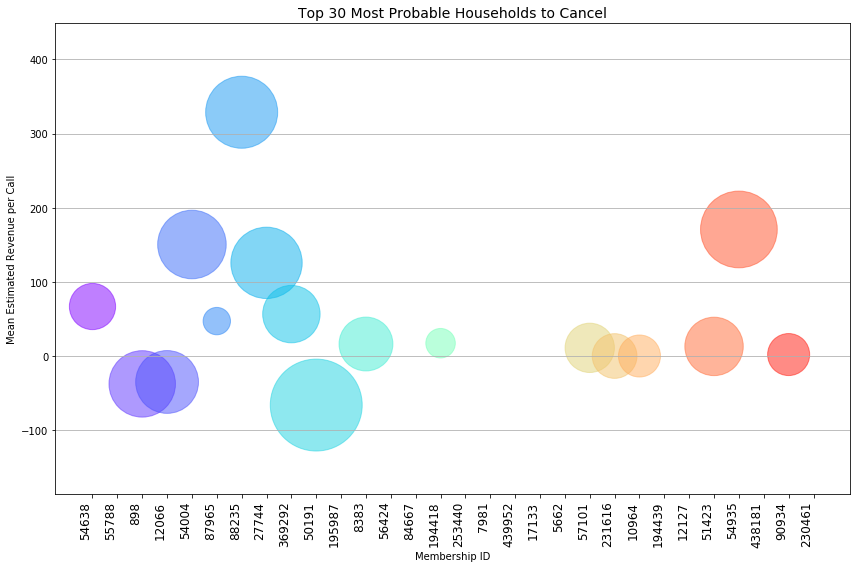

In [230]:
# Graph Time series per household cancel
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','will_cancel_prob', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.will_cancel_prob != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['will_cancel_prob', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members['mean_estimated_revenue'], 
            s=top_members['mean_total_cost']*100, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue per Call")
plt.xlabel("Membership ID")
plt.title("Top 30 Most Probable Households to Cancel", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='y')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [137]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 97 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

In [91]:
df_ts = df_ts[(df_ts.will_cancel_prob != 1)]
threshold = 0.5
df_ts = df_ts[(df_ts.will_cancel_prob >= threshold)]
df_ts.mean_estimated_revenue.sum(), df_ts.mean_estimated_revenue.count()

(5331.646764000001, 207)

In [71]:
top_members.rename(columns={"mean_total_member_cost": "Mean Member Cost", 'mean_total_cost':'Mean Total AAA Costs', 
                            'will_cancel_prob': "Probability to Cancel", 'mean_estimated_revenue': 'Est. Mean Revenue Loss'
                           },inplace=True)
top_members.drop(columns=['membership_id', 'member_status'], inplace=True)
fig = ff.create_table(top_members, height_constant=30, index=True)
fig.write_image('./model_pics/cancel/'+'aaa_cancel_top_member_to_cancel.png')
py.iplot(fig)

In [266]:
df_ts = pd.DataFrame(df_household, columns=['total_member_cost','total_cost','will_cancel_prob', 'member_status'])
df_ts['estimated_revenue'] = df_ts['total_member_cost'] - df_ts['total_cost']
df_ts = df_ts[(df_ts.will_cancel_prob != 1)]
threshold = 0.0
df_ts = df_ts[(df_ts.will_cancel_prob >= threshold)]
df_ts.estimated_revenue.sum(), df_ts.estimated_revenue.count()

(1040965.3699999999, 2937)

In [99]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 97 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

In [124]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])

In [291]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
#df_use = df_use[(df_use.yes_roadside != 1)]
df_use.T.mean(axis=1)

yes_roadside         0.9330
yes_auto_insurance   0.5155
yes_credit_card      0.2066
yes_travel           0.2926
yes_id_theft         0.2222
yes_deposit          0.0890
yes_home_equity      0.0081
will_cancel_prob     0.6081
dtype: float64

In [313]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
print(df_use.T.mean(axis=1),'\n\n')

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_roadside != 1)]
print("Roadside mean prob : ", df_use.T.mean(axis=1).yes_roadside)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_auto_insurance != 1)]
print("Insurance mean prob : ", df_use.T.mean(axis=1).yes_auto_insurance)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_travel != 1)]
print("Travel mean prob : ", df_use.T.mean(axis=1).yes_travel)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_credit_card != 1)]
print("Credit Card mean prob : ", df_use.T.mean(axis=1).yes_credit_card)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_id_theft != 1)]
print("ID theft mean prob : ", df_use.T.mean(axis=1).yes_id_theft)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_deposit != 1)]
print("Deposit mean prob : ", df_use.T.mean(axis=1).yes_deposit)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_home_equity != 1)]
print("Home Equity prob  : ", df_use.T.mean(axis=1).yes_home_equity)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_mortgage != 1)]
print("Financial Service Equity prob  : ", df_use.T.mean(axis=1).yes_mortgage)

yes_roadside         0.9330
yes_auto_insurance   0.5155
yes_credit_card      0.2066
yes_travel           0.2926
yes_id_theft         0.2222
yes_deposit          0.0890
yes_home_equity      0.0081
will_cancel_prob     0.6081
yes_mortgage         0.2830
dtype: float64 


Roadside mean prob :  0.8493387681159422
Insurance mean prob :  0.3402362580567217
Travel mean prob :  0.19978141409288935
Credit Card mean prob :  0.1401431959547143
ID theft mean prob :  0.1868181818181817
Deposit mean prob :  0.08459620506142032
Home Equity prob  :  0.0032524271844660197
Financial Service Equity prob  :  0.26525302530253025


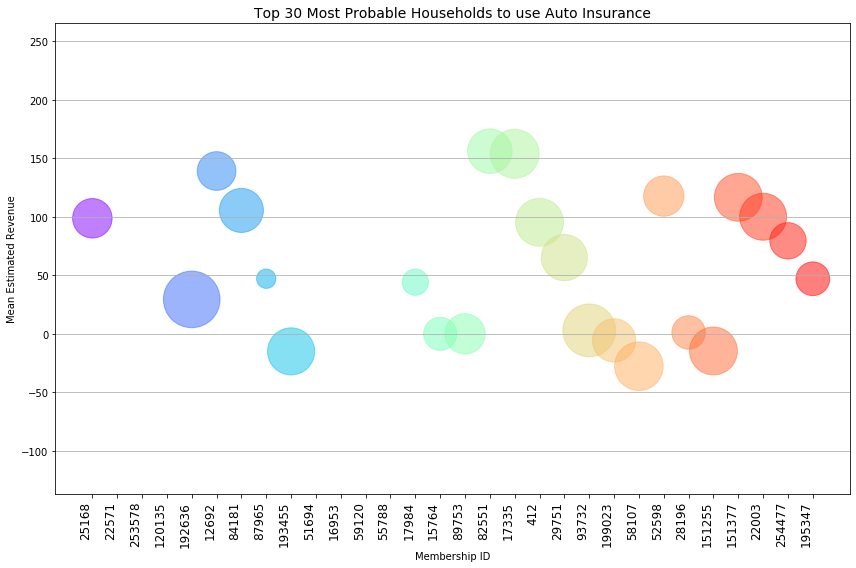

In [254]:
# Graph Time series per household auto insurance
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_auto_insurance', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_auto_insurance != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['yes_auto_insurance', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members['mean_estimated_revenue'], 
            s=top_members['mean_total_cost']*50, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Membership ID")
plt.title("Top 30 Most Probable Households to use Auto Insurance", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='y')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [255]:
top_members

,mean_total_member_cost,mean_total_cost,yes_auto_insurance,member_status,mean_estimated_revenue,membership_id
membership_id,,,,,,
25168,130.0000,31.2500,0.7400,ACTIVE,98.7500,25168
22571,15.2500,0.0000,0.7317,ACTIVE,15.2500,22571
253578,55.9250,0.0000,0.7100,ACTIVE,55.9250,253578
120135,29.4250,0.0000,0.7100,ACTIVE,29.4250,120135
192636,93.5625,64.1375,0.7100,ACTIVE,29.4250,192636
12692,169.1333,30.0000,0.6800,ACTIVE,139.1333,12692
84181,144.3175,38.8500,0.6800,ACTIVE,105.4675,84181
87965,54.5850,7.5000,0.6800,ACTIVE,47.0850,87965
193455,29.4250,44.4250,0.6800,ACTIVE,-15.0000,193455


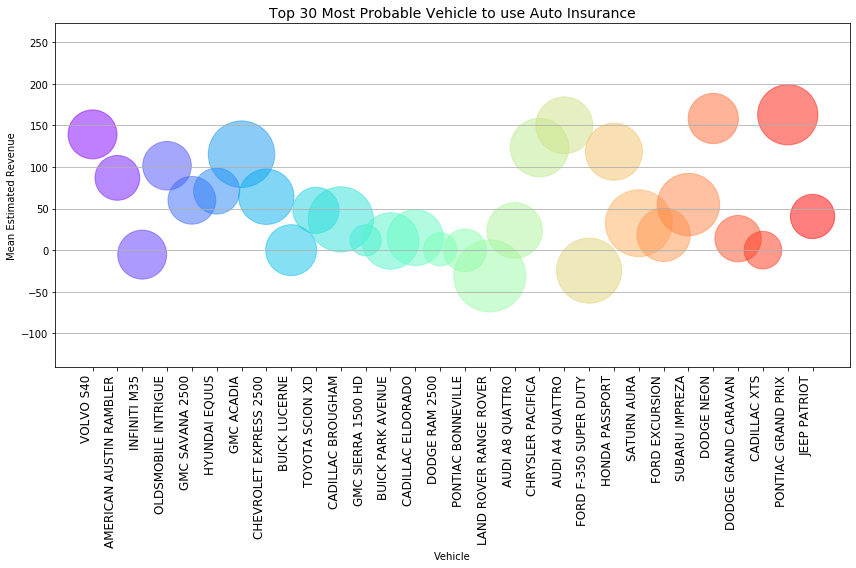

In [253]:
# Graph Time series per household auto insurance
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_auto_insurance', 
                                            'vehicle', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.member_status != 'CANCELLED')]
t_membership_id = t_membership_id[(t_membership_id.vehicle != 'UNKNOWN UNKNOWN')]
t_membership_id = t_membership_id[(t_membership_id.yes_auto_insurance != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='vehicle').mean()
top_members = top_members.nlargest(30, columns=['yes_auto_insurance','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.index, y=top_members['mean_estimated_revenue'], 
            s=top_members['mean_total_cost']*80, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Vehicle")
plt.title("Top 30 Most Probable Vehicle to use Auto Insurance", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='y')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [212]:
top_members

,mean_total_member_cost,mean_total_cost,yes_auto_insurance,mean_estimated_revenue
vehicle,,,,
VOLVO S40,169.1333,30.0000,0.6800,139.1333
AMERICAN AUSTIN RAMBLER,112.0000,25.0909,0.6100,86.9091
INFINITI M35,24.6667,30.0000,0.6000,-5.3333
OLDSMOBILE INTRIGUE,131.0000,29.5417,0.5900,101.4583
GMC SAVANA 2500,88.3980,28.4700,0.5900,59.9280
HYUNDAI EQUUS,97.4950,26.5000,0.5800,70.9950
GMC ACADIA,170.7000,55.3400,0.5700,115.3600
CHEVROLET EXPRESS 2500,102.5694,38.3548,0.5567,64.2146
BUICK LUCERNE,32.5000,32.5000,0.5400,0.0000


In [265]:
df_ts = pd.DataFrame(df_household, columns=['total_member_cost','total_cost','yes_auto_insurance', 
                                            'vehicle', 'member_status'])
df_ts['estimated_revenue'] = df_ts['total_member_cost'] - df_ts['total_cost']
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts = df_ts[(df_ts.vehicle != 'UNKNOWN UNKNOWN')]
df_ts = df_ts[(df_ts.yes_auto_insurance != 1)]
threshold = 0.
df_ts = df_ts[(df_ts.yes_auto_insurance >= threshold)]
df_ts.estimated_revenue.sum(), df_ts.estimated_revenue.count()

(622451.8, 1399)

In [284]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob'
                                           ])
df_use = df_use[(df_use.yes_auto_insurance !=1)]
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
#df_use = df_use[(df_use.yes_roadside != 1)]
df_use.T.mean(axis=1)

yes_roadside         0.9485
yes_auto_insurance   0.5789
yes_credit_card      0.4837
yes_travel           0.3751
yes_id_theft         0.3203
yes_deposit          0.0828
yes_home_equity      0.0066
will_cancel_prob     0.2598
dtype: float64

In [283]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob'
                                           ])
df_use = df_use[(df_use.yes_auto_insurance !=1)]
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_credit_card != 1)]
df_use.T.mean(axis=1)

yes_roadside         0.9436
yes_auto_insurance   0.5839
yes_credit_card      0.1551
yes_travel           0.3331
yes_id_theft         0.2973
yes_deposit          0.1036
yes_home_equity      0.0009
will_cancel_prob     0.3117
dtype: float64

In [314]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
print(df_use.T.mean(axis=1),'\n\n')

# RoadSide
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_roadside != 1)]
print("Roadside mean prob : ", df_use.T.mean(axis=1).yes_roadside)

# Travel
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_travel != 1)]
print("Travel mean prob : ", df_use.T.mean(axis=1).yes_travel)

# Credit Card
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_credit_card != 1)]
print("Credit Card mean prob : ", df_use.T.mean(axis=1).yes_credit_card)

# Id Theft
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_id_theft != 1)]
print("ID theft mean prob : ", df_use.T.mean(axis=1).yes_id_theft)

# Deposit
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_deposit != 1)]
print("Deposit mean prob : ", df_use.T.mean(axis=1).yes_deposit)

# Home Equity
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_home_equity != 1)]
print("Home Equity prob  : ", df_use.T.mean(axis=1).yes_home_equity)

# Home Equity
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_mortgage != 1)]
print("Mortgage Equity prob  : ", df_use.T.mean(axis=1).yes_mortgage)

yes_roadside         0.9485
yes_auto_insurance   0.5789
yes_credit_card      0.4837
yes_travel           0.3751
yes_id_theft         0.3203
yes_deposit          0.0828
yes_home_equity      0.0066
will_cancel_prob     0.2598
yes_mortgage         0.4472
dtype: float64 


Roadside mean prob :  0.8113135593220338
Travel mean prob :  0.18687036240198887
Credit Card mean prob :  0.15509090909090897
ID theft mean prob :  0.27534101825168095
Deposit mean prob :  0.037822859983979135
Home Equity prob  :  0.004471326164874547
Mortgage Equity prob  :  0.2952873965255917
